This notebook demonstrates how to use the global_sampler class to perform an MCMC analysis of EDGES data. 

Text(0.5,1,'ABC123 vs $\\mathrm{ABC123}^{123}$')

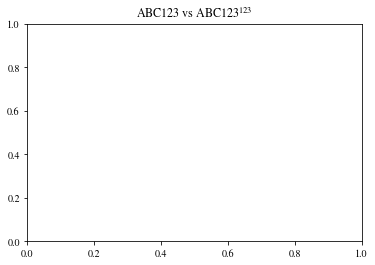

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os,sys
import corner
sys.path.append(os.path.abspath('../edges/'))
import global_sampler as GS
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.pyplot.title(r'ABC123 vs $\mathrm{ABC123}^{123}$')

To initialize our sampler, we simply create an isntance of the Sampler class that points to our configuration file. The configuration file allows you to specify the order of the foreground polynomial, which terms to vary (or hold fixed), and also options for MCMC length, number of walkers, etc...

In [2]:
sampler=GS.Sampler('../config/example.yaml')

Here is the filtered variance compared to the square of the EDGES residual. 

Text(0,0.5,'Var($T_b$) (mK)')

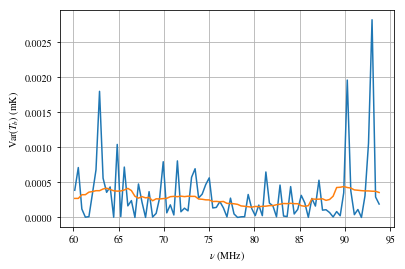

In [3]:
plt.plot(sampler.freqs,np.abs(sampler.dtb)**2.)
plt.plot(sampler.freqs,sampler.var_tb)
plt.grid()
plt.xlabel('$\\nu$ (MHz)')
plt.ylabel('Var($T_b$) (mK)')

To fit the data and perform MCMC, just call sampler.sample().

In [4]:
print(type(sampler.config['COMPUTECOVARIANCE']))

<class 'bool'>


In [5]:
sampler.sample()

['AFG0', 'AFG1', 'AFG2', 'AFG3', 'AFG4']
['NU0', 'TAU', 'A', 'W']
{'NU0': {'TYPE': 'VARY', 'P0': 78.3, 'PRIOR': 'UNIFORM', 'MIN': 0.0, 'MAX': 1000.0}, 'TAU': {'TYPE': 'VARY', 'P0': 6.5, 'PRIOR': 'UNIFORM', 'MIN': -100, 'MAX': 10000}, 'A': {'TYPE': 'VARY', 'P0': 0.52, 'PRIOR': 'UNIFORM', 'MIN': 0.0, 'MAX': 1000.0}, 'W': {'TYPE': 'VARY', 'P0': 20.7, 'PRIOR': 'UNIFORM', 'MIN': 0.0, 'MAX': 1000.0}, 'AFG0': {'TYPE': 'VARY', 'P0': 1700.0, 'PRIOR': 'UNIFORM', 'MIN': -10000, 'MAX': 10000}, 'AFG1': {'TYPE': 'VARY', 'P0': 600.0, 'PRIOR': 'UNIFORM', 'MIN': -10000, 'MAX': 10000}, 'AFG2': {'TYPE': 'VARY', 'P0': -1200.0, 'PRIOR': 'UNIFORM', 'MIN': -10000, 'MAX': 10000}, 'AFG3': {'TYPE': 'VARY', 'P0': 750.0, 'PRIOR': 'UNIFORM', 'MIN': -10000, 'MAX': 10000}, 'AFG4': {'TYPE': 'VARY', 'P0': -175.0, 'PRIOR': 'UNIFORM', 'MIN': -10000, 'MAX': 10000}}
{'NU0': 78.19248036181872, 'TAU': 6.208755070598689, 'A': 0.5723449611418114, 'W': 18.686475220322485, 'AFG0': 1713.543422362702, 'AFG1': -20.5201242466218, '

Lets take a look at the chains (after reomoving 10,0000 burn points). 

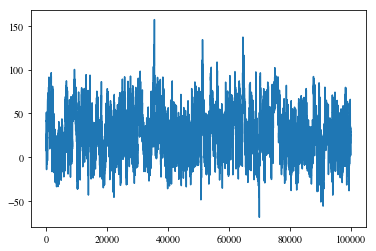

In [6]:
samples=sampler.sampler.chain.reshape((-1, sampler.ndim))
plt.plot(samples[:100000,8])

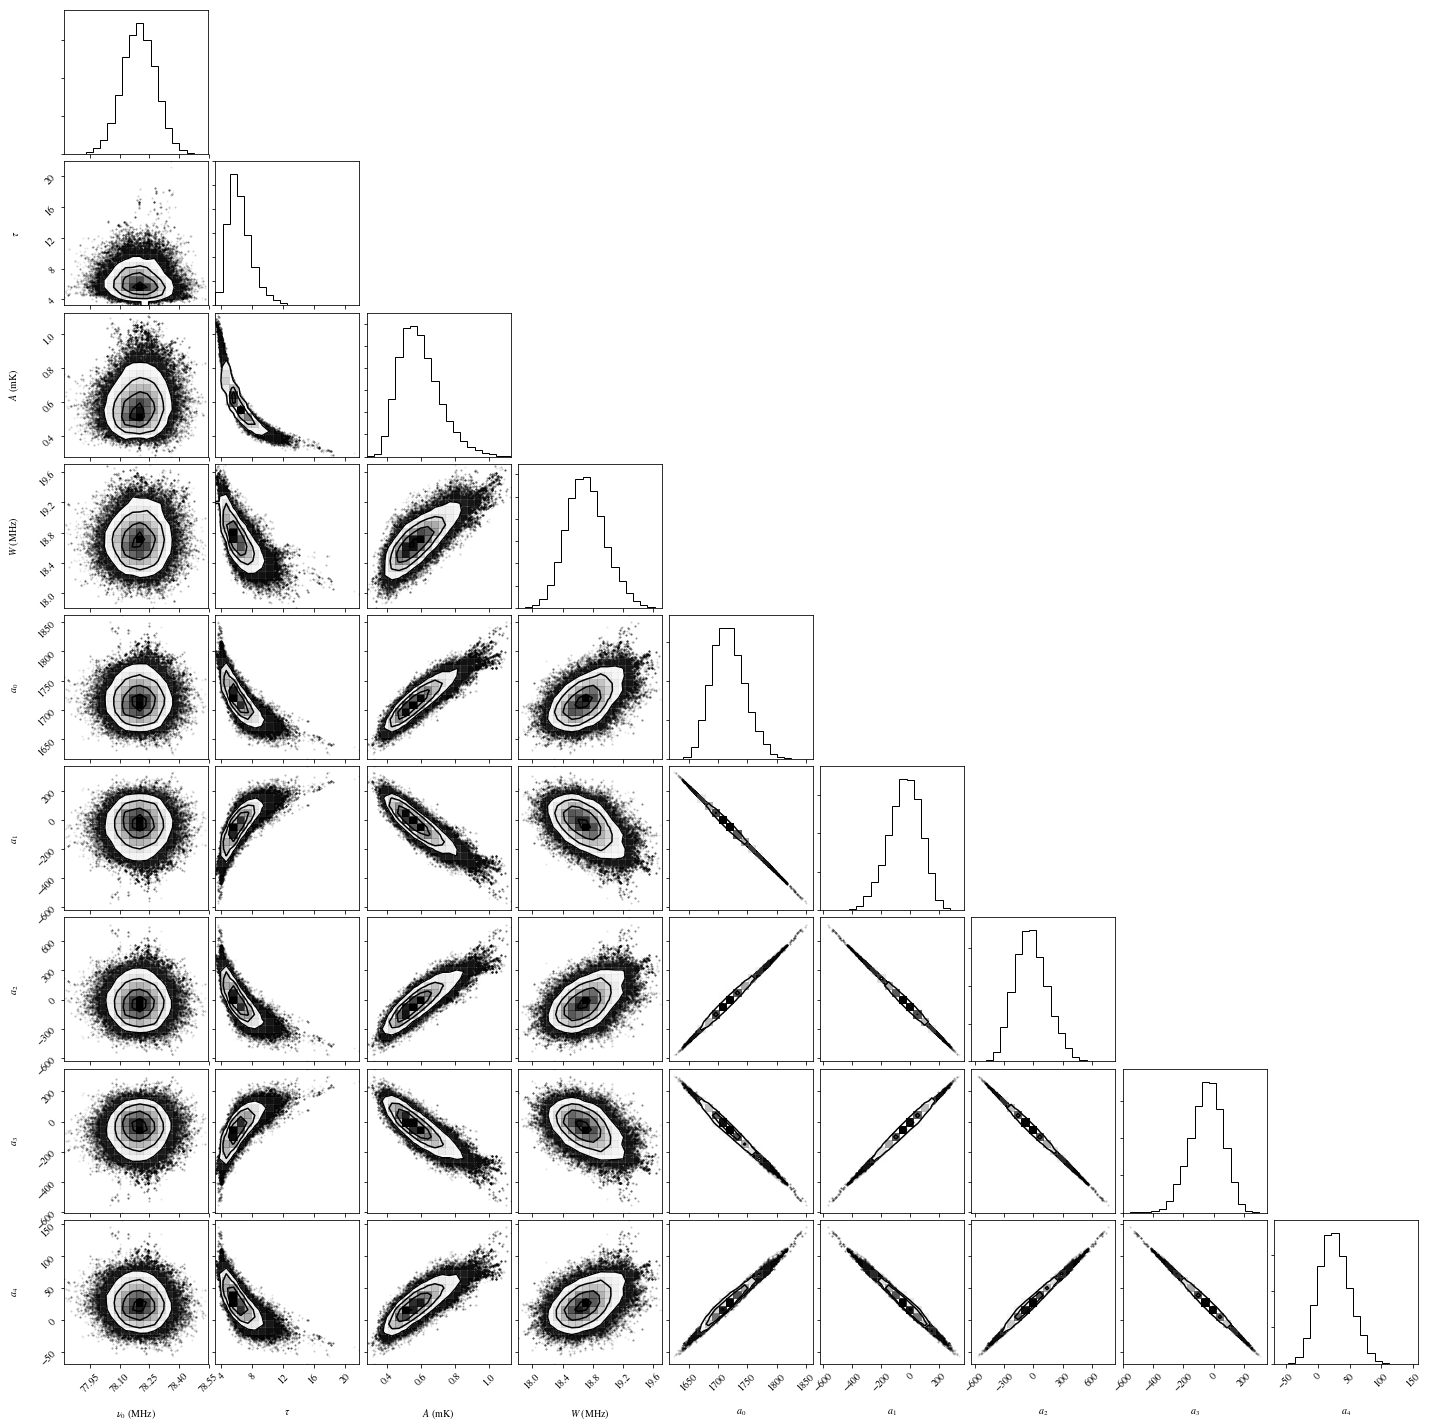

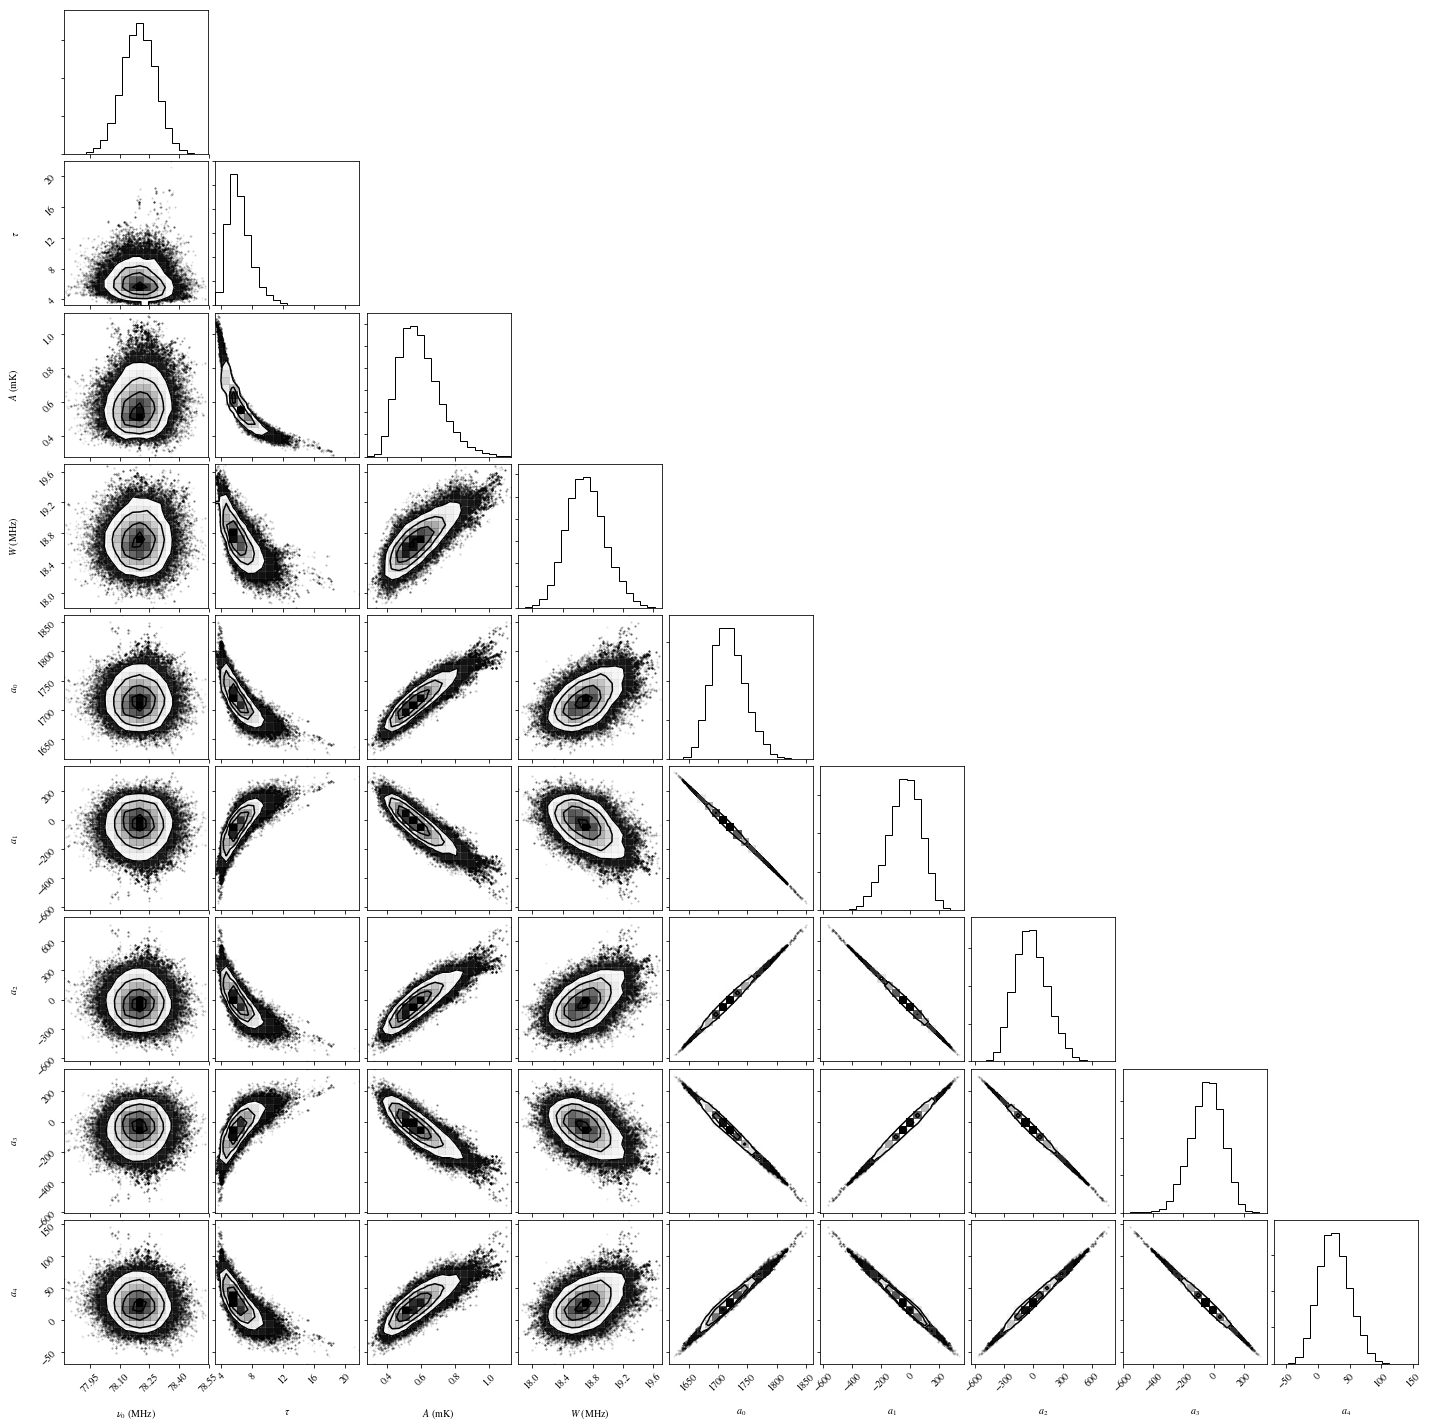

In [7]:
corner.corner(samples,
labels=('$\\nu_0$ (MHz)','$\\tau$','$A$ (mK)','$W$ (MHz)','$a_0$','$a_1$','$a_2$','$a_3$','$a_4$'))

Plot the maximum likelihood model, some draws, and the model

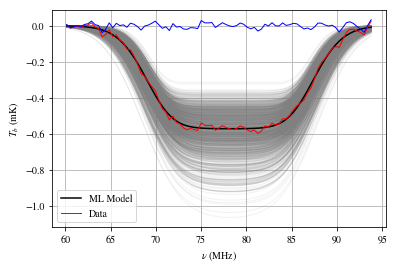

In [8]:
import imp
imp.reload(GS)
ndraws=1000
for drawnum in range(ndraws):
    draw=np.random.randint(0,sampler.config['NSTEPS']*sampler.config['NWALKERS'])
    params={'NU0':samples[draw,0],'TAU':samples[draw,1],'A':samples[draw,2],'W':samples[draw,3]}
    plt.plot(sampler.freqs,GS.delta_Tb_analytic(sampler.freqs,**params),color='grey',lw=1,alpha=.1)
l1=plt.plot(sampler.freqs,GS.TbSky(sampler.ml_params,sampler.freqs,sampler.params_all,[])\
        -GS.Tbfg(sampler.freqs,sampler.params_all),color='k')[0]
l2=plt.plot(sampler.freqs,sampler.tb_meas-GS.Tbfg(sampler.freqs,sampler.params_all),color='r',lw=1)[0]
#l3=plt.plot(sampler.freqs,sampler.tb_meas-GSBH_MCMC.TbSky(ml_samples,sampler.freqs,
#sampler.params_all,[],sampler.analytic),color='blue',lw=1)[0]
l3=plt.plot(sampler.freqs,sampler.resid,color='blue',lw=1)[0]
#plt.ylim(-.6,.1)
plt.xlabel('$\\nu$ (MHz)')
plt.ylabel('$T_b$ (mK)')
plt.legend((l1,l2),('ML Model','Data'))
plt.grid()